# Installation

This demo requires Hugging Face [`Transformers`](https://github.com/huggingface/transformers) for the model, and the IBM `tsfm` package for auxiliary data pre-processing.
We can install both by cloning the `tsfm` repository and following the below steps.


😈 **Task 1:** Explore what `PatchTST` offers compared to traditional transformers. What’s unique about the patching mechanism?


1. Clone the public IBM Time Series Foundation Model Repository [`tsfm`](https://github.com/ibm/tsfm).

2. Install Hugging Face [`Transformers`](https://github.com/huggingface/transformers#installation)

3. Test it with the following commands in a `python` terminal.


In [1]:
!pip install git+https://github.com/IBM/tsfm.git transformers tf_keras

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-cflj5typ
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-cflj5typ
  Resolved https://github.com/IBM/tsfm.git to commit 7449f9dfcdef3bf0fa7779170360cbf57af665fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import PatchTSTConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset

## Part 1: Forecasting on the TOAR dataset
Here we train a `PatchTST` model directly on the TOAR normalized data similar to TOAR huggingface example and evaluate its performance.

😈 **Question 1:** Why might a transformer model be well-suited for air quality forecasting?

😈 **Task 2:** Compare PatchTST against LSTM or MLP. What trends do you notice?


In [2]:
# Standard
import os

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    set_seed,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

# supress some warnings
import warnings

warnings.filterwarnings("ignore", module="torch")

c:\Users\s.vasired\miniconda3\envs\myenv_labex\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set seed

😈 **Task 3:** Try changing the seed and observe if training results vary significantly.


In [3]:
set_seed(2025)

### Load and prepare datasets

 In the next cell, please adjust the following parameters to suit your application:
 - `dataset_path`: path to local .csv file, or web address to a csv file for the data of interest. Data is loaded with pandas, so anything supported by
   `pd.read_csv` is supported: (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
 - `timestamp_column`: column name containing timestamp information, use `None` if there is no such column.
 - `id_columns`: List of column names specifying the IDs of different time series. If no ID column exists, use `[]`.
 - `forecast_columns`: List of columns to be modeled
 - `context_length`: The amount of historical data used as input to the model. Windows of the input time series data with length equal to `context_length` will be extracted from the input dataframe. In the case of a multi-time series dataset, the context windows will be created so that they are contained within a single time series (i.e., a single ID).
 - `forecast_horizon`: Number of timestamps to forecast in the future.
 - `train_start_index`, `train_end_index`: the start and end indices in the loaded data which delineate the training data.
 - `valid_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the validation data.
 - `test_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the test data.
 - `patch_length`: The patch length for the `PatchTST` model. It is recommended to choose a value that evenly divides `context_length`.
 - `num_workers`: Number of CPU workers in the PyTorch dataloader.
 - `batch_size`: Batch size.

The data is first loaded into a Pandas dataframe and split into training, validation, and test parts. Then the Pandas dataframes are converted to the appropriate PyTorch dataset required for training.

😈 **Task 4:** Change `context_length` or `patch_length` and compare validation loss.

😈 **Question 2:** Why does `patch_length` need to divide `context_length` evenly?


In [4]:
# TOAR normalized data is loaded from r"/content/normalized_data.csv"
dataset_path = r"/content/timeseries_data/raw_data.csv"
timestamp_column = "datetime"
id_columns = ['station_code','latitude','longitude']

context_length = 336
forecast_horizon = 96
patch_length = 16
num_workers = 16  # Reduce this if you have low number of CPU cores
batch_size = 64  # Adjust according to GPU memory

In [5]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
data = data[data['station_code'] == "DENW094"]
observable_columns = ["no2", "temp", "o3", "no", "press"]
target_columns = observable_columns #["o3"]

# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=observable_columns,
    output_columns=target_columns,
    scaling=True,
)
time_series_preprocessor = time_series_preprocessor.train(train_data)

Note: Input and output columns have been renamed target and observable columns in the newer version of tsfm not reflected in huggingface notebook

😈 **Task 5:** Update the code to reflect `tsfm`’s new naming and ensure compatibility.


In [6]:
train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

### Configure the PatchTST model

Next, we instantiate a randomly initialized `PatchTST` model with a configuration. The settings below control the different hyperparameters related to the architecture.
  - `num_input_channels`: the number of input channels (or dimensions) in the time series data. This is
    automatically set to the number for forecast columns.
  - `context_length`: As described above, the amount of historical data used as input to the model.
  - `patch_length`: The length of the patches extracted from the context window (of length `context_length`).
  - `patch_stride`: The stride used when extracting patches from the context window.
  - `random_mask_ratio`: The fraction of input patches that are completely masked for pretraining the model.
  - `d_model`: Dimension of the transformer layers.
  - `num_attention_heads`: The number of attention heads for each attention layer in the Transformer encoder.
  - `num_hidden_layers`: The number of encoder layers.
  - `ffn_dim`: Dimension of the intermediate (often referred to as feed-forward) layer in the encoder.
  - `dropout`: Dropout probability for all fully connected layers in the encoder.
  - `head_dropout`: Dropout probability used in the head of the model.
  - `pooling_type`: Pooling of the embedding. `"mean"`, `"max"` and `None` are supported.
  - `channel_attention`: Activate the channel attention block in the Transformer to allow channels to attend to each other.
  - `scaling`: Whether to scale the input targets via "mean" scaler, "std" scaler, or no scaler if `None`. If `True`, the
    scaler is set to `"mean"`.
  - `loss`: The loss function for the model corresponding to the `distribution_output` head. For parametric
    distributions it is the negative log-likelihood (`"nll"`) and for point estimates it is the mean squared
    error `"mse"`.
  - `pre_norm`: Normalization is applied before self-attention if pre_norm is set to `True`. Otherwise, normalization is
    applied after residual block.
  - `norm_type`: Normalization at each Transformer layer. Can be `"BatchNorm"` or `"LayerNorm"`.

For full details on the parameters, we refer to the [documentation](https://huggingface.co/docs/transformers/main/en/model_doc/patchtst#transformers.PatchTSTConfig).

😈 **Task 6:** Test `dropout`, `d_model`, and `num_attention_heads` variations to understand their impact.

😈 **Question 3:** What’s the difference between `LayerNorm` and `BatchNorm`, and when might one be preferred over the other?



In [7]:
config = PatchTSTConfig(
    num_input_channels=len(observable_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.4,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

### Optional
 if you would like to use wandb

😈 **Task 7:** Log additional metrics like MAE or custom visualizations in wandb.


In [ ]:
# !export WANDB_API_KEY=<Your-API-Key>
# !pip install wandb
# !wandb login

### Train model

Next, we can leverage the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class to train the model based on the direct forecasting strategy. We first define the [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) which lists various hyperparameters for training such as the number of epochs, learning rate and so on.

😈 **Task 8:** Implement early stopping. How does it affect training duration and validation loss?


In [8]:
training_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/TOAR/pretrain/output/",
    overwrite_output_dir=True,
    # learning_rate=0.001,
    num_train_epochs=10,
    do_eval=True,
    eval_strategy="epoch", # previously evaluation_strategy
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/TOAR/pretrain/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

In [10]:
# pretrain
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vasireddysindhu70 (vasireddysindhu70-jsc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.410200,0.237525
2,0.390300,0.228527
3,0.381600,0.225255
4,0.372800,0.224899
5,0.363600,0.226248
6,0.354400,0.226626


TrainOutput(global_step=46092, training_loss=0.37881504950357436, metrics={'train_runtime': 1832.8667, 'train_samples_per_second': 2682.105, 'train_steps_per_second': 41.912, 'total_flos': 1.963617913829376e+16, 'train_loss': 0.37881504950357436, 'epoch': 6.0})

### Evaluate the model on the test set of the source domain

Next, we can leverage `trainer.evaluate()` to calculate test metrics. While this is not the target metric to judge in this task, it provides a reasonable check that the pretrained model has trained properly.
Note that the training and evaluation loss for `PatchTST` is the Mean Squared Error (MSE) loss. Hence, we do not separately compute the MSE metric in any of the following evaluation experiments.

😈 **Task 9:** Visualize forecast vs. actual values to visually inspect quality.

😈 **Question 4:** What are the limitations of using only MSE for evaluation?


In [11]:
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)

Test result:
{'eval_loss': 0.17259475588798523, 'eval_runtime': 52.1056, 'eval_samples_per_second': 2696.123, 'eval_steps_per_second': 42.145, 'epoch': 6.0}


### Save model

😈 **Task 10:** Save multiple checkpoints and compare predictions from different training stages.


In [12]:
save_dir = "./checkpoint/patchtst/TOAR/model/pretrain/"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

## Reload Trained Model

😈 **Task 11:** Load a saved model and apply it to a completely new station’s dataset.


In [9]:
trained_forecast_model = PatchTSTForPrediction.from_pretrained(
    "./checkpoint/patchtst/TOAR/model/pretrain/",
    num_input_channels=len(observable_columns),
    dropout=0.7,
    head_dropout=0.7,
)
## make sure the othervariables are recreated from cells before pretraining
re_trainer = Trainer(
    model=trained_forecast_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

## Predict and Plot

😈 **Task 12:** Compare predictions across stations. Which station is easier to forecast and why?


In [10]:
raw_predictions = re_trainer.predict(test_dataset)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: sindhuvasireddy94 (sindhu-vasireddy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


(140483, 96, 5)

### Continuity


> Plotting in line with MLP and LSTM

😈 **Question 5:** What benefits do attention-based models offer over recurrent models in forecasting scenarios?



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [12]:
# Function to create time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    for i in range(n_past, len(data) - n_future):
        X.append(data[i - n_past:i])
        y.append(data[i:i + n_future])
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [13]:
variable_columns = ["no2", "temp", "o3", "no", "press"]
context_window = 336
prediction_horizon = 96
X, y = create_sequences(data[variable_columns].values,context_window,prediction_horizon)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} for col in variable_columns}

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (561969, 336, 5), y_train shape: (561969, 96, 5)
X_test shape: (140493, 336, 5), y_test shape: (140493, 96, 5)


## Plot

😈 **Task 13:** Add confidence intervals or highlight anomalies in the prediction plots.


act: [1.13547246 1.24404104 1.28023056 1.32280032 1.36537008 1.40793983
 1.45050959 1.49307935 1.52832753 1.56357571 1.59882388 1.63407206
 1.66932024 1.67088915 1.67245806 1.67402697 1.67559588 1.67716479
 1.61012004 1.54307528 1.47603053 1.40898577 1.34194102 1.2848327
 1.22772437 1.17061605 1.11350772 1.0563994  1.04886863 1.04133786
 1.0338071  1.02627633 1.01874556 1.04447568 1.07020581 1.09593593
 1.12166606 1.14739618 1.18923378 1.23107138 1.27290898 1.31474658
 1.35658418 1.35731634 1.3580485  1.35878065 1.35951281 1.36024497
 1.36798493 1.37572488 1.38346484 1.39120479 1.39894475 1.37175031
 1.34455587 1.31736143 1.29016699 1.26297255 1.29633804 1.32970352
 1.36306901 1.39643449 1.42979998 1.39486558 1.35993119 1.32499679
 1.2900624  1.255128   1.2045045  1.15388101 1.10325751 1.05263402
 1.00201052 0.99353841 0.98506629 0.97659418 0.96812206 0.95964995
 0.93057282 0.90149569 0.87241855 0.84334142 0.81426429 0.81436888
 0.81447348 0.81457807 0.81468267 0.81478726 0.98778574 1.

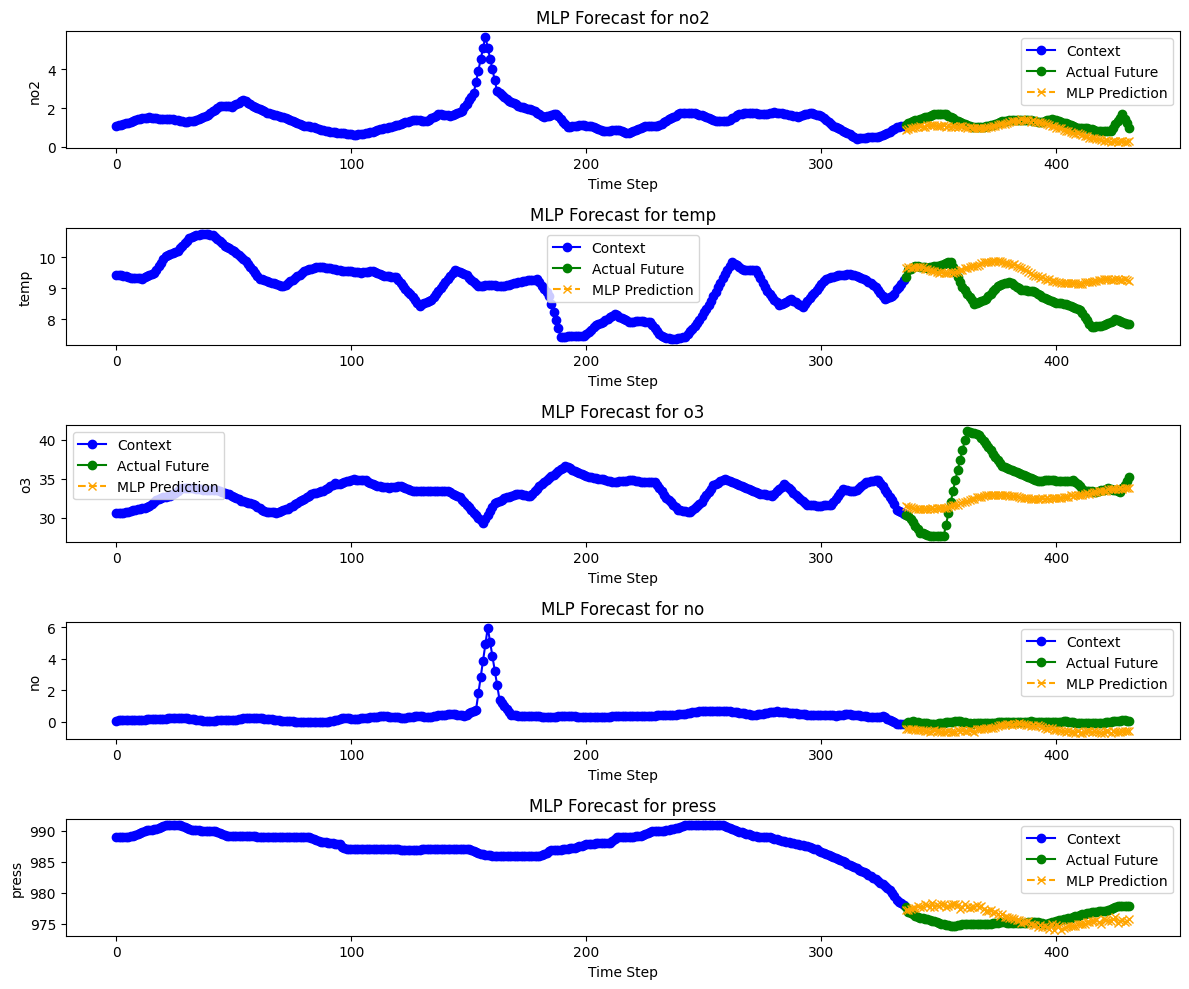

In [14]:
plt.figure(figsize=(12, 10))
num_variables = len(variable_columns)
scaler_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} for col in variable_columns}

for variable_idx in range(num_variables):
    # Last sample
    sample_idx = -1
    X_test_sample = X_test[sample_idx, :, variable_idx]
    y_test_sample = y_test[sample_idx, :, variable_idx]

    # Inverse scale
    context = X_test_sample
    actual_future = y_test_sample
    predicted_future = patchtst_predictions[-1, :, variable_idx] * scaler_stats[variable_columns[variable_idx]]['std'] + scaler_stats[variable_columns[variable_idx]]['mean']
    print(f"act: {actual_future} \n pred {predicted_future}")
    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_columns[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_columns[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()
